# Concise Implementation of Softmax Regression
Just as high-level deep learning frameworks made it easier to implement linear regression (see Section 3.5), they are similarly convenient here.

## Defining the Model

As in Section 3.5, we construct our fully connected layer using the built-in layer. We use a `flatten` layer to reshape arbitrarly-shaped input into a matrix-shaped output, preserving the size of the last dimension..

In [1]:
using Flux
model = Chain(Flux.flatten,Dense(28*28=>10))

Chain(
  Flux.flatten,
  Dense(784 => 10),                     # 7_850 parameters
) 


This avoids both overflow and underflow. We will want to keep the conventional softmax function handy in case we ever want to evaluate the output probabilities by our model. But instead of passing softmax probabilities into our new loss function, we just pass the logits and compute the softmax and its log all at once inside the cross-entropy loss function, which does smart things like the “LogSumExp trick”.

In [2]:
loss(model,x,y) = Flux.logitcrossentropy(model(x),y)

loss (generic function with 1 method)

## Training

Next we train our model. We use Fashion-MNIST images, flattened to 784-dimensional feature vectors.

In [3]:
using MLUtils
using MLDatasets
using MLBase

# data prepare
ENV["DATADEPS_ALWAYS_ACCEPT"] = true
mnist_train,mnist_test = FashionMNIST(:train),FashionMNIST(:test)
features = mnist_train.features
labels = Flux.onehotbatch(mnist_train.targets,0:9)
train_loader = DataLoader((features,labels),batchsize=256)

mnist_accuracy(model, data::FashionMNIST) = correctrate(classify(model(data.features)).-1,data.targets)

# train
num_epochs = 10
results = map(1:num_epochs) do i
    for data in train_loader
        Flux.train!(loss,model,[data],Descent())
    end
    loss(model,features,labels),mnist_accuracy(model,mnist_train),mnist_accuracy(model, mnist_test)
end
train_loss, train_acc, test_acc = map(x->getindex.(results,x),1:3)

3-element Vector{Vector}:
 Float32[0.6151819, 0.5413316, 0.5090037, 0.4895458, 0.47606862, 0.4659756, 0.45803085, 0.45155552, 0.44613948, 0.44151744]
 [0.79765, 0.8203666666666667, 0.8302166666666667, 0.836, 0.8398, 0.8427333333333333, 0.84545, 0.84745, 0.8488333333333333, 0.85015]
 [0.7829, 0.8083, 0.8187, 0.8246, 0.8269, 0.8282, 0.8309, 0.8326, 0.8345, 0.8342]

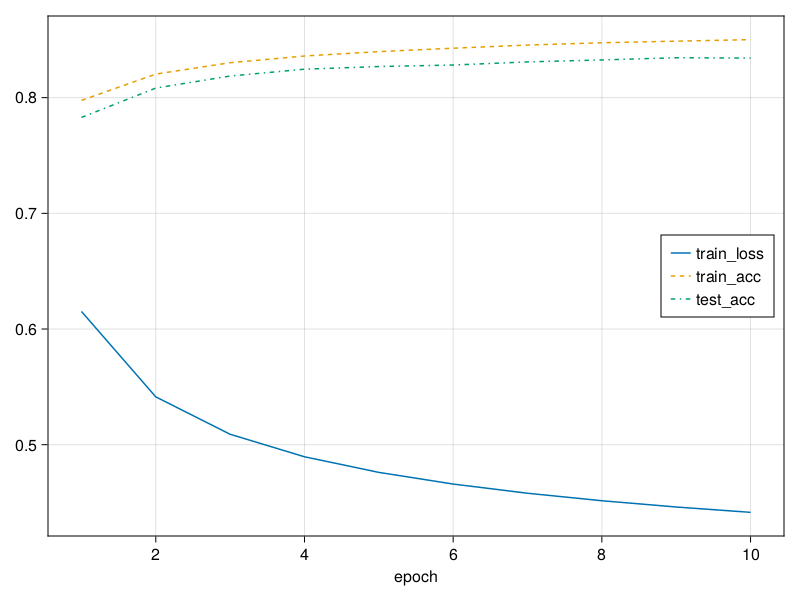

In [12]:
using CairoMakie

f,ax = lines(train_loss,label="train_loss";axis=(;xlabel="epoch"))
lines!(ax,train_acc,label="train_acc",linestyle=:dash)
lines!(ax,test_acc,label="test_acc",linestyle=:dashdot)
axislegend(position = :rc)
f